Understanding the Data

In [36]:
import os

base_path = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data"

# Updated subfolders
for folder in ["Training1", "Training2", "Testing1", "Testing2"]:
    print(f"\n{folder.upper()}")
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        for cls in os.listdir(folder_path):
            cls_path = os.path.join(folder_path, cls)
            if os.path.isdir(cls_path):
                count = len(os.listdir(cls_path))
                print(f"{cls}: {count} images")
    else:
        print(f"Folder not found: {folder_path}")


TRAINING1
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

TRAINING2
glioma: 826 images
meningioma: 822 images
notumor: 395 images
pituitary: 827 images

TESTING1
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images

TESTING2
glioma: 100 images
meningioma: 115 images
notumor: 105 images
pituitary: 74 images


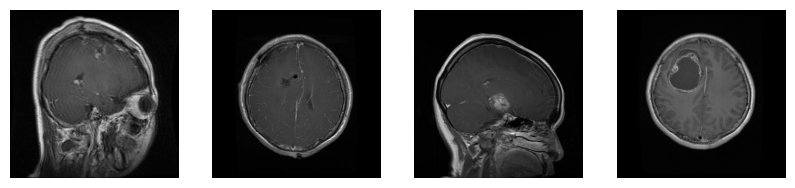

In [37]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Pick one of the training subfolders
folder = os.path.join(base_path, "training1", "glioma")  # or "training2"

# Sample 4 random images
sample_images = random.sample(os.listdir(folder), 4)

plt.figure(figsize=(10, 4))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [38]:
import cv2

img = cv2.imread(os.path.join(folder, sample_images[0]))
print("Image shape:", img.shape)

Image shape: (512, 512, 3)


Data Augmentation

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training folders
train_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training1"
train_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training2"

# Test folders (used as validation)
test_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing1"
test_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing2"

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

def augment_and_preprocess(x):
    x = tf.image.adjust_contrast(x, 1.5)
    return preprocess_input(x)

train_datagen = ImageDataGenerator(
    preprocessing_function=augment_and_preprocess,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Data Generators
train_gen1 = train_datagen.flow_from_directory(
    train_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

train_gen2 = train_datagen.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

test_gen1 = test_datagen.flow_from_directory(
    test_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_gen2 = test_datagen.flow_from_directory(
    test_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [41]:
# Wrap the generator
def generator_to_dataset(gen):
    return tf.data.Dataset.from_generator(
        lambda: gen,
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, 224, 224, 3), (None, 4))  # batch dimension = None
    )

# Create datasets
ds_train1 = generator_to_dataset(train_gen1)
ds_train2 = generator_to_dataset(train_gen2)
ds_test1 = generator_to_dataset(test_gen1)
ds_test2 = generator_to_dataset(test_gen2)

# Combine
train_dataset = ds_train1.concatenate(ds_train2)
test_dataset = ds_test1.concatenate(ds_test2)

# DO NOT call .batch() here — batches are already in the generator

Visualizing Augmented Data

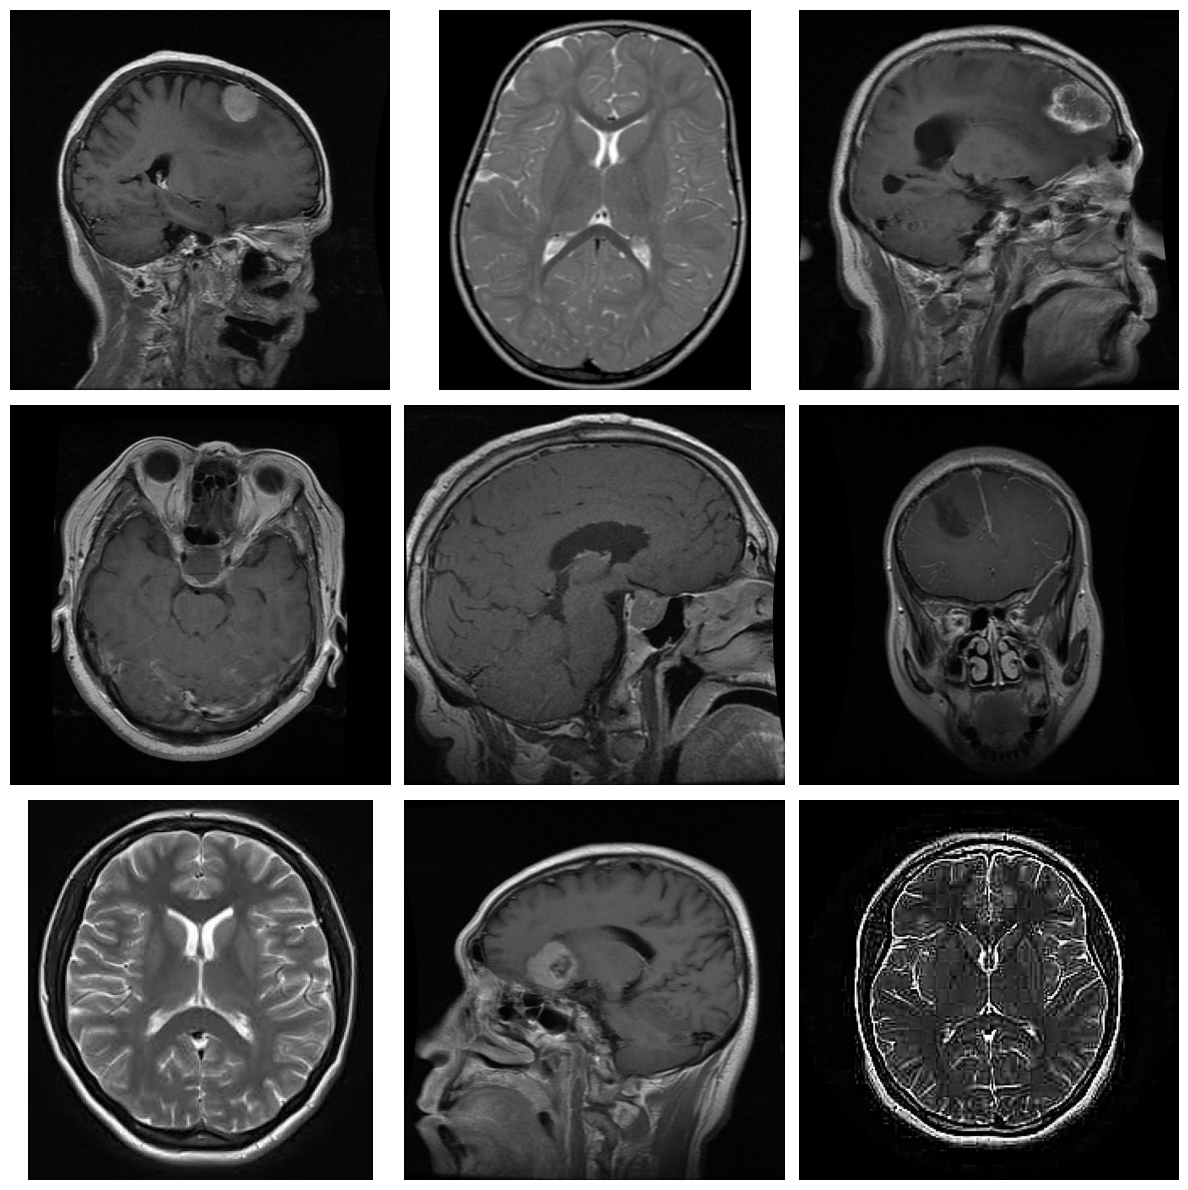

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random

# Define your training subfolders
training_folders = [train_dir1, train_dir2]

num_images_to_show = 9  # total images to visualize
sample_paths = []

# Collect all class subfolders
all_class_subfolders = []
for folder in training_folders:
    all_class_subfolders += [os.path.join(folder, cls) for cls in os.listdir(folder) if os.path.isdir(os.path.join(folder, cls))]

# Randomly pick 9 images across all classes and folders
while len(sample_paths) < num_images_to_show:
    cls_folder = random.choice(all_class_subfolders)
    img_name = random.choice(os.listdir(cls_folder))
    sample_paths.append(os.path.join(cls_folder, img_name))

# Load images and apply simple augmentations
augmented_images = []
for path in sample_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Simple augmentations
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_flip_left_right(img)
    augmented_images.append(img)

# Deprocess for visualization
def deprocess_mri_image(x):
    x = (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x) + 1e-8)
    return x.numpy()

# Plot augmented images in 3x3 grid
rows = 3
cols = 3
plt.figure(figsize=(12, 12))  # bigger figure for large images
for i, img in enumerate(augmented_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(deprocess_mri_image(img), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Transfer Learning

Pre-trained CNN (ConvNeXt-Tiny IMAGENET1K_V1)

In [43]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

Load Pretrained RadImageNet Model (No Top)

In [44]:
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Freeze all layers (feature extraction phase)

In [45]:
for layer in base_model.layers:
    layer.trainable = False

Add Classification Head

In [46]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.4)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

Compilation and Callbacks

In [47]:
early_stop1 = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_convnext_model.keras', monitor='val_accuracy', save_best_only=True)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

Compute Class Weights

In [48]:
from sklearn.utils import class_weight

all_classes = np.concatenate([train_gen1.classes, train_gen2.classes])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_classes),
    y=all_classes
)
class_weights = dict(enumerate(class_weights))

Training Phase 1: Train Head

In [49]:
callbacks_phase1 = [early_stop1, reduce_lr, checkpoint]
steps_per_epoch = len(train_gen1) + len(train_gen2)  # sum of batches from both generators
validation_steps = len(test_gen1) + len(test_gen2)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_phase1,
    class_weight=class_weights
)

Epoch 1/50


269/269 ━━━━━━━━━━━━━━━━━━━━ 1494s 6s/step - accuracy: 0.6601 - loss: 1.1134 - val_accuracy: 0.7441 - val_loss: 1.0647 - learning_rate: 1.0000e-04
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1488s 6s/step - accuracy: 0.8047 - loss: 0.8626 - val_accuracy: 0.7834 - val_loss: 0.8110 - learning_rate: 1.0000e-04
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1447s 5s/step - accuracy: 0.8415 - loss: 0.7860 - val_accuracy: 0.8384 - val_loss: 0.7346 - learning_rate: 1.0000e-04
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1499s 6s/step - accuracy: 0.8698 - loss: 0.7366 - val_accuracy: 0.8107 - val_loss: 0.7800 - learning_rate: 1.0000e-04
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1493s 6s/step - accuracy: 0.8829 - loss: 0.7106 - val_accuracy: 0.8425 - val_loss: 0.7246 - learning_rate: 1.0000e-04
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1445s 5s/step - accuracy: 0.8946 - loss: 0.6936 - val_accuracy: 0.8888 - val_loss: 0.6692 - learning_rate: 1.0000e-04
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1437s 5s/step - accurac

Fine-Tuning Phase

In [50]:
fine_tune_fraction = 0.2
n_layers = len(base_model.layers)
n_unfreeze = int(n_layers * fine_tune_fraction)

for layer in base_model.layers[-n_unfreeze:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print(f"Unfreezing the last {n_unfreeze} layers out of {n_layers}")

Unfreezing the last 26 layers out of 133


Recompile with lower LR

In [51]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

Fine-tune Callbacks

In [52]:
early_stop_finetune = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr_finetune = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
checkpoint_finetune = ModelCheckpoint('fine_tuned_convnext_model.keras', monitor='val_accuracy', save_best_only=True)
callbacks_finetune = [early_stop_finetune, reduce_lr_finetune, checkpoint_finetune]

Training Phase 2: Fine-Tune

In [53]:
steps_per_epoch = len(train_gen1) + len(train_gen2)
validation_steps = len(test_gen1) + len(test_gen2)

history_finetune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_finetune,
    class_weight=class_weights
)

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2292s 8s/step - accuracy: 0.9884 - loss: 0.4936 - val_accuracy: 0.9415 - val_loss: 0.5496 - learning_rate: 1.0000e-05
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2273s 8s/step - accuracy: 0.9899 - loss: 0.4916 - val_accuracy: 0.9525 - val_loss: 0.5310 - learning_rate: 1.0000e-05
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2356s 9s/step - accuracy: 0.9926 - loss: 0.4884 - val_accuracy: 0.9577 - val_loss: 0.5273 - learning_rate: 1.0000e-05
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2411s 9s/step - accuracy: 0.9908 - loss: 0.4867 - val_accuracy: 0.9461 - val_loss: 0.5485 - learning_rate: 1.0000e-05
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2297s 9s/step - accuracy: 0.9922 - loss: 0.4850 - val_accuracy: 0.9664 - val_loss: 0.5161 - learning_rate: 1.0000e-05
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2292s 9s/step - accuracy: 0.9949 - loss: 0.4834 - val_accuracy: 0.9571 - val_loss: 0.5221 - learning_rate: 1.0000e-05
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2296s 9s/ste

Load Best Model for Evaluation

In [54]:
model = tf.keras.models.load_model("fine_tuned_convnext_model.keras")

## Evaluation

c:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step
Overall Accuracy: 0.9261

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.84      0.87       400
  meningioma       0.90      0.88      0.89       421
     notumor       0.95      1.00      0.97       510
   pituitary       0.95      0.97      0.96       374

    accuracy                           0.93      1705
   macro avg       0.92      0.92      0.92      1705
weighted avg       0.93      0.93      0.93      1705



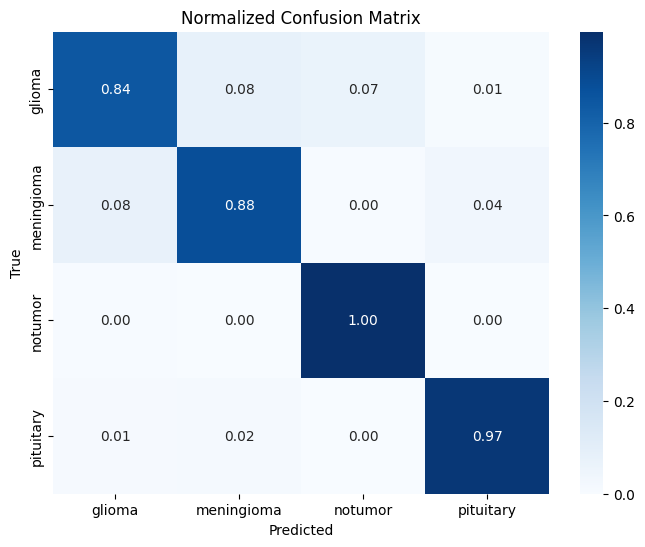

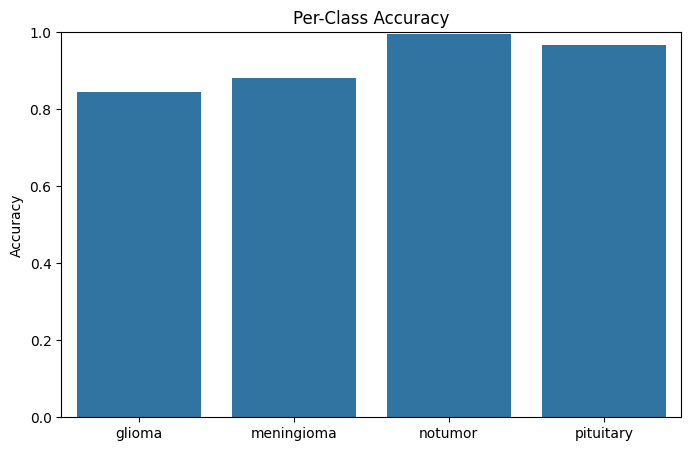

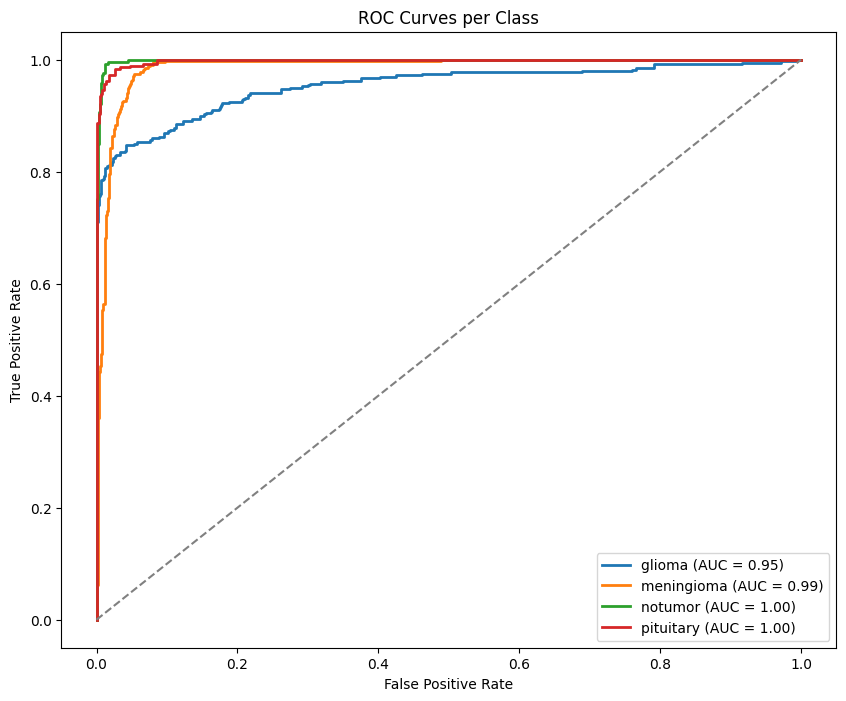

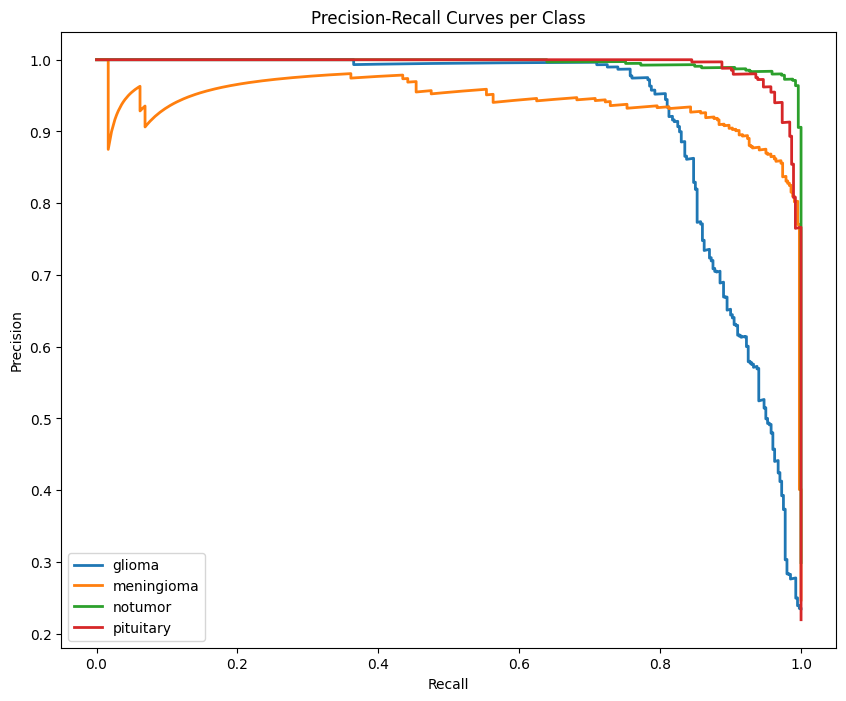

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
import tensorflow as tf

# -----------------------------
# 1. Load model
# -----------------------------
model = load_model("fine_tuned_convnext_model.keras")

# -----------------------------
# 2. Predictions on combined test set
# -----------------------------
test_generators = [test_gen1, test_gen2]
y_preds_prob = []
y_trues = []

for gen in test_generators:
    y_prob = model.predict(gen)
    y_true = gen.classes
    y_preds_prob.append(y_prob)
    y_trues.append(y_true)

y_true = np.concatenate(y_trues)
y_preds_prob = np.concatenate(y_preds_prob)
y_pred = np.argmax(y_preds_prob, axis=1)

class_labels = list(test_gen1.class_indices.keys())
n_classes = len(class_labels)

# -----------------------------
# 3. Basic Metrics
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Per-class Accuracy Bar Plot
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=per_class_acc)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()

# -----------------------------
# 4. ROC & AUC (One-vs-Rest)
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_preds_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 5. Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_preds_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f"{class_labels[i]}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Class")
plt.legend(loc="lower left")
plt.show()